## Imports and preprocessing

In [40]:
%matplotlib inline
import scipy
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from smart_mobility_utilities.common import probability
import math
import random

# Largest Piece First First Fit

In [41]:
df = pd.read_csv("/Users/yilunli/Desktop/ECE1724_Team10_Project/DatasetGen/synthetic_dataset.csv")
df.rename(columns = {'Number Deliveries':'demand'}, inplace=True)
df.sort_values(by=['demand'], ascending=False, inplace=True)
print(df.columns.tolist())
demands = df["demand"]
df = df[["X", "Y"]]
# df["Y"] -= 3000
data = df.to_numpy()

sa_location = "/Users/yilunli/Desktop/ECE1724_Team10_Project/Algorithms/SA/k1_lam0.1_sa_locations.csv"
ga_location = "/Users/yilunli/Desktop/ECE1724_Team10_Project/Algorithms/GA/mut0.9_covr0.9_ga_locations.csv"
kmeans_location = "/Users/yilunli/Desktop/ECE1724_Team10_Project/Distribution/k-means/Kmeans_cluster.csv"
facilities = pd.read_csv(sa_location)
facilities = facilities[["x", "y"]]
# facilities["y"] -= 3000
depots = facilities.to_numpy()

['Node ID', 'Node OSMID', 'X', 'Y', 'Node Weight', 'demand']


In [42]:
min_bid_rent_multiplier = 0.7
# estimated_dtwn_x = 0
# estimated_dtwn_y = 0

max_distance_to_dtwn = np.max(np.linalg.norm(data, axis=1))#np.sqrt(271935.72891419794)
min_distance_to_dtwn = np.min(np.linalg.norm(data, axis=1))

In [43]:
np.max(np.linalg.norm(depots, axis=1))

495.76667492366124

In [44]:
capacity_perfacility = 1200
capacities = capacity_perfacility * np.ones(depots.shape[0])
def get_multiplier(min_bid_rent_multiplier, min_distance_to_dtwn, max_distance_to_dtwn, depot_norm):
    return (1 - min_bid_rent_multiplier *\
                 (depot_norm - min_distance_to_dtwn)\
            / (max_distance_to_dtwn - min_distance_to_dtwn)) 

In [45]:
result = np.zeros((data.shape[0], depots.shape[0]))
cost = 0
for i in range(data.shape[0]):
    node = data[i]
    distances = np.linalg.norm(depots - node, axis=1)
    distances = get_multiplier(min_bid_rent_multiplier, min_distance_to_dtwn,\
                               max_distance_to_dtwn, np.linalg.norm(depots, axis=1))*distances
    min_distance_depot = np.argsort(distances)
    for j in min_distance_depot:
        if capacities[j] == 0:
            continue
        if capacities[j] >= demands[i]:
            cost += distances[j] * (demands[i]/1200)
            result[i][j] += demands[i]
            capacities[j] -= demands[i]
            demands[i] = 0
            break
        else:
            cost += distances[j] * (demands[i]/1200)
            result[i][j] += capacities[j]
            demands[i] -= capacities[j]
            capacities[j] = 0
        if demands[i] <= 0:
            break

Verification

In [46]:
print(f"total cost: {cost}")
print(f"left over capacities: {np.sum(capacities[np.nonzero(capacities)[0]])}")
print(f"remaining demand: {np.sum(demands)}")

total cost: 83382.97368784864
left over capacities: 9200.0
remaining demand: 0


# SA

In [47]:
df = pd.read_csv("/Users/yilunli/Desktop/ECE1724_Team10_Project/DatasetGen/synthetic_dataset.csv")
df.rename(columns = {'Number Deliveries':'demand'}, inplace=True)
df.sort_values(by=['demand'], ascending=False, inplace=True)
print(df.columns.tolist())
demands = df["demand"].to_numpy()
df = df[["X", "Y"]]
# df["Y"] -= 3000
data = df.to_numpy()

facilities = pd.read_csv(sa_location)
facilities = facilities[["x", "y"]]
# facilities["y"] -= 3000
depots = facilities.to_numpy()

['Node ID', 'Node OSMID', 'X', 'Y', 'Node Weight', 'demand']


In [48]:
def exp_schedule(k=20, lam=0.005, limit=100):
    function = lambda t: (k * np.exp(-lam*t) if t <limit else 0)
    return function

def random_search(coords, volumes, locations): 
    cap = capacity_perfacility * np.ones(locations.shape[0])
    indices = np.arange(coords.shape[0])
    np.random.shuffle(indices)
    da, ds = np.copy(coords)[indices], np.copy(volumes)[indices]
    r = np.zeros((da.shape[0], locations.shape[0]))
    c = 0
    for i in range(da.shape[0]):
        node = da[i]
        distances = np.linalg.norm(locations - node, axis=1)
        distances = get_multiplier(min_bid_rent_multiplier, min_distance_to_dtwn,\
                               max_distance_to_dtwn, np.linalg.norm(depots, axis=1)) * distances
        min_distance_depot = np.argsort(distances)
        for j in min_distance_depot:
            if cap[j] == 0:
                continue
            if cap[j] >= ds[i]:
                c += distances[j] * (ds[i]/1200)
                r[i][j] += ds[i]
                cap[j] -= ds[i]
                ds[i] = 0
                break
            else:
                c += distances[j] * (ds[i]/1200)
                r[i][j] += cap[j]
                ds[i] -= cap[j]
                cap[j] = 0
            if ds[i] <= 0:
                break
    return r, c

In [49]:
def simulated_annealing(initial_solution, num_iter, schedule_function, neighbour_function, coords, volume, locations):
    current, current_cost = initial_solution
    assert(current_cost != 0)
    states = [current_cost]
    solutions = [current]
    for t in range(num_iter):
        T = schedule_function(t)
        next_choice, next_cost = neighbour_function(coords, volume, locations)
        current_cost = states[-1]
        delta_e = next_cost - current_cost
        if delta_e < 0 or probability(np.exp(-1 * delta_e / T)):
            current = next_choice
            states.append(next_cost)
            solutions.append(current)
        else: 
            states.append(current_cost)
    return current, states[-1], states

In [50]:
distribution_solution = np.zeros((data.shape[0], depots.shape[0]))
num_iterations = 100
exp_schedule_k = 100
exp_schedule_lam = 0.05
total_cost = 0

schedule = exp_schedule(exp_schedule_k, exp_schedule_lam, num_iterations)
initial_solution = (result, cost)
distribution_solution, total_cost, cost_curve = simulated_annealing(
    initial_solution,
    num_iterations,
    schedule,
    random_search,
    np.copy(data),
    np.copy(demands),
    np.copy(depots)
    )

In [51]:
left_over_capacity = np.sum(capacity_perfacility * np.ones(depots.shape[0]) - np.sum(distribution_solution, axis=0))

print(f"total cost: {total_cost}")
print(f"left over capacities: {np.sum(left_over_capacity)}")
print(f"remaining demand: {np.sum(demands - np.sum(distribution_solution, axis=1))}")

total cost: 57685.48203453891
left over capacities: 9200.0
remaining demand: 0.0


Text(0.5, 1.0, 'Demand Assignment cost on SA locations')

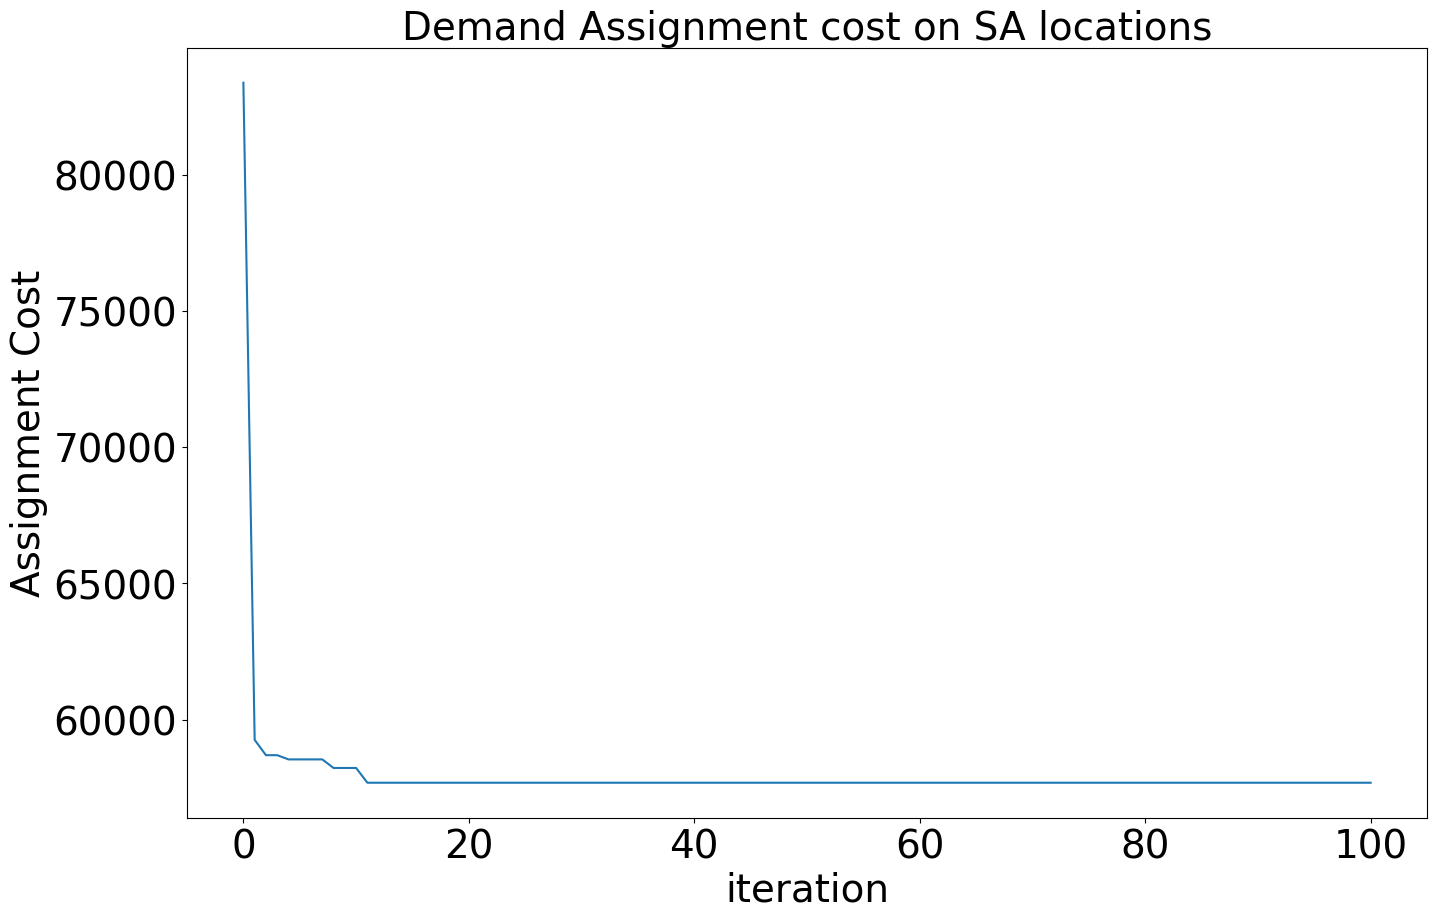

In [52]:
plt.plot(cost_curve)
plt.xlabel('iteration')
plt.ylabel('Assignment Cost')
plt.title('Demand Assignment cost on SA locations')

In [53]:
cost_curve[-1]

57685.48203453891

In [54]:
result.shape

(5797, 841)

In [55]:
depots.shape

(841, 2)

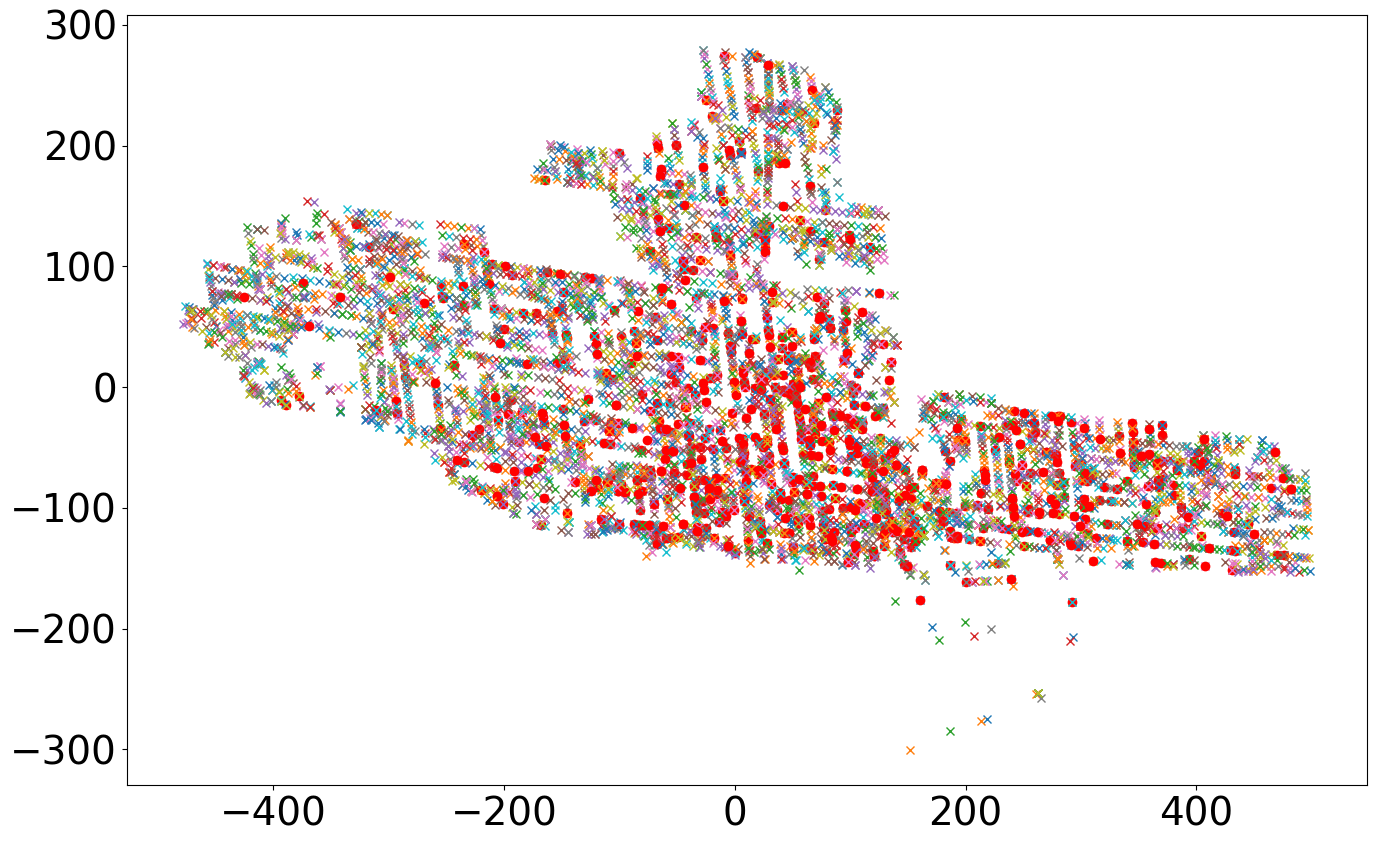

In [62]:
# from matplotlib.animation import FuncAnimation, PillowWriter
# writer = PillowWriter(fps=24)
# large = 32; med = 28; small = 24
# params = {'axes.titlesize': large,
#                     'legend.fontsize': large,
#                     'figure.figsize': (16, 10),
#                     'axes.labelsize': med,
#                     'axes.titlesize': med,
#                     'xtick.labelsize': med,
#                     'ytick.labelsize': med,
#                     'figure.titlesize': large}
# plt.rcParams.update(params)
# fig2 = plt.figure(figsize=(16,8), dpi= 80)
# plt.ylabel("Y Coordinate of Node", fontsize=med)  
# plt.xlabel("X Coordinate of Node", fontsize=med) 
# plt.title("Progression of Delivery Center Locations Over Time", fontsize=large)
# # plt.xlim((self.min_x, self.max_x))
# # plt.ylim((self.min_y, self.max_y))
# animation_points = []
# with writer.saving(fig2, "tmp.gif", 100):
#     for i in range(0, result.shape[1]):
#         # x_coordinates = []
#         # y_coordinates = []
#         # for facility in data:
#         #     x_coordinates.append(facility[0])
#         #     y_coordinates.append(facility[1])
#         # print(np.nonzero(result[:, i]))
#         nodes_served = data[np.nonzero(result[:, i])]
#         # print(nodes_served.shape)
        
#         # def sub_plot():
#         fig = plt.figure()
#         plt.scatter(depots[i][0], depots[i][1], color="blue")
#         plt.scatter(nodes_served[:,0], nodes_served[:, 1], color="#FF0000")
           
#             # return fig
#         animation_points.append(fig) 
#         plt.close()
#         writer.grab_frame()
#         # x = animation_points.append()
#         # if len(animation_points) == 2:
#             # animation_points[0].remove()
#             # animation_points.pop(0)

for i in range(distribution_solution.shape[1]):
  cluster = np.where(distribution_solution[:, i]) 
  plt.plot(depots[i][0], depots[i][1], "o", color="#FF0000")
  plt.plot(data[cluster][:, 0], data[cluster][:, 1], "x")